In [1]:
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
import pandas as pd
import numpy as np
import itertools
import os
import gc
import random
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-04-09 11:00:12.463329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 11:00:12.463456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 11:00:12.607979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.DataFrame(glob("/kaggle/input/trim-data/TrimedDataset/Train/*/*"), columns=['video'])
train_df['label'] = train_df['video'].apply(lambda x: x.split('/')[-2])
train_df = train_df.drop(
    train_df
    [(train_df['label'] == 'Normal_Videos_for_Event_Recognition') |
     (train_df['label'] == 'RoadAccidents') |
     (train_df['label'] == 'Arrest')
    ].index)
train_df = train_df.groupby('label').sample(10)
train_df.label.value_counts()

label
Abuse          10
Arson          10
Assault        10
Explosion      10
Fighting       10
Normal         10
Shooting       10
Shoplifting    10
Vandalism      10
Name: count, dtype: int64

In [3]:
val_df = pd.DataFrame(glob("/kaggle/input/trim-data/TrimedDataset/Valid/*/*"), columns=['video'])
val_df['label'] = val_df['video'].apply(lambda x: x.split('/')[-2])
val_df = val_df.drop(
    val_df
    [(val_df['label'] == 'Normal_Videos_for_Event_Recognition') |
     (val_df['label'] == 'RoadAccidents') |
     (val_df['label'] == 'Arrest')
    ].index)
val_df = train_df.groupby('label').sample(7)
val_df.label.value_counts()

label
Abuse          7
Arson          7
Assault        7
Explosion      7
Fighting       7
Normal         7
Shooting       7
Shoplifting    7
Vandalism      7
Name: count, dtype: int64

In [4]:
test_df = pd.DataFrame(glob("/kaggle/input/trim-data/TrimedDataset/Test/*/*"), columns=['video'])
test_df['label'] = test_df['video'].apply(lambda x: x.split('/')[-2])
test_df = test_df.drop(
    test_df
    [(test_df['label'] == 'Normal_Videos_for_Event_Recognition') |
     (test_df['label'] == 'RoadAccidents') |
     (test_df['label'] == 'Arrest')
    ].index)
test_df = train_df.groupby('label').sample(6)
test_df.label.value_counts()

label
Abuse          6
Arson          6
Assault        6
Explosion      6
Fighting       6
Normal         6
Shooting       6
Shoplifting    6
Vandalism      6
Name: count, dtype: int64

In [5]:
mappings = dict()
classes = train_df.label.unique()
for x in range(len(classes)):
    mappings[classes[x]] = x
mappings

{'Abuse': 0,
 'Arson': 1,
 'Assault': 2,
 'Explosion': 3,
 'Fighting': 4,
 'Normal': 5,
 'Shooting': 6,
 'Shoplifting': 7,
 'Vandalism': 8}

In [6]:
mappings_inv = dict()
for x in range(len(mappings)):
    mappings_inv[x] = classes[x]

In [7]:
mappings_inv

{0: 'Abuse',
 1: 'Arson',
 2: 'Assault',
 3: 'Explosion',
 4: 'Fighting',
 5: 'Normal',
 6: 'Shooting',
 7: 'Shoplifting',
 8: 'Vandalism'}

In [8]:
import cv2
maxframes=32
def load_video(path, maxframes=maxframes):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        cap.release()
    frames = np.array(frames)
    t_frames = frames.shape[0]
    if t_frames < maxframes:
        frames = tf.concat([
                frames, 
                tf.repeat(frames[-1][None, :, :, :], repeats=maxframes-t_frames, axis=0)
        ], axis=0)
    else:
        to_pick = t_frames//maxframes
        frames = frames[0::to_pick][:maxframes]
        
    frames = tf.image.resize(frames, (224, 224))/255
    gc.collect()
    return frames

In [9]:
x_train = []
y_train = []
x_val = []
y_val = []

for x in tqdm(train_df[['video', 'label']].values, position=0, leave=True):
    x, y = x
    x = load_video(x)
    y = mappings[y]
    x_train.append(x)
    y_train.append(y)
    gc.collect()

100%|██████████| 90/90 [00:59<00:00,  1.52it/s]


In [10]:
for x in tqdm(val_df[['video', 'label']].values, position=0, leave=True):
    x, y = x
    x = load_video(x)
    y = mappings[y]
    x_val.append(x)
    y_val.append(y)
    gc.collect()

100%|██████████| 63/63 [00:40<00:00,  1.57it/s]


In [11]:
x_test = []
y_test = []
for x in tqdm(test_df[['video', 'label']].values, position=0, leave=True):
    x, y = x
    x = load_video(x)
    y = mappings[y]
    x_test.append(x)
    y_test.append(y)
    gc.collect()

100%|██████████| 54/54 [00:34<00:00,  1.55it/s]


In [12]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

gc.collect()

0

In [13]:
gc.collect()

0

In [14]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

(((90, 32, 224, 224, 3), (90,)),
 ((63, 32, 224, 224, 3), (63,)),
 ((54, 32, 224, 224, 3), (54,)))

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(5)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(5)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(5)

In [16]:
pretrained = tf.keras.models.load_model("/kaggle/input/videoswin/tensorflow2/base/1/TFVideoSwinB_K400_IN1K_P244_W877_32x224")

In [17]:
pretrained.trainable=False

In [18]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model

In [19]:
tf.keras.backend.clear_session()
gc.collect()

0

In [20]:
ip1 = tf.keras.Input(shape=(32, 224, 224, 3))
embed = pretrained(ip1)
embed = Dense(256, activation='relu')(embed)
embed = Dropout(0.4)(embed)

op = Dense(len(mappings), activation='softmax')(embed)
model = Model(ip1, op)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 224, 224, 3   0         
                             )]                                  
                                                                 
 TFVideoSwinB_K400_IN1K_P24  (None, 400)               88048984  
 4_W877_32x224 (TFSwinTrans                                      
 former3D)                                                       
                                                                 
 dense (Dense)               (None, 256)               102656    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                             

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(x_train, y_train, epochs=50, batch_size=1, validation_data=(x_val, y_val), callbacks = [tf.keras.callbacks.ModelCheckpoint(
    'model.h5',
    save_best_only=True,
    save_weights_only=True
)])

Epoch 1/50


I0000 00:00:1712660658.768334      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 [==============================] - 88s 617ms/step - loss: 4.4682 - accuracy: 0.1222 - val_loss: 2.2788 - val_accuracy: 0.2857
Epoch 2/50
90/90 [==============================] - 46s 518ms/step - loss: 3.2846 - accuracy: 0.1222 - val_loss: 1.5836 - val_accuracy: 0.4286
Epoch 3/50
90/90 [==============================] - 46s 517ms/step - loss: 2.5851 - accuracy: 0.2000 - val_loss: 1.1305 - val_accuracy: 0.6032
Epoch 4/50
90/90 [==============================] - 46s 516ms/step - loss: 2.1709 - accuracy: 0.3111 - val_loss: 0.8876 - val_accuracy: 0.7143
Epoch 5/50
90/90 [==============================] - 46s 517ms/step - loss: 1.9254 - accuracy: 0.3889 - val_loss: 0.7136 - val_accuracy: 0.8095
Epoch 6/50
90/90 [==============================] - 46s 517ms/step - loss: 1.6064 - accuracy: 0.4111 - val_loss: 0.5825 - val_accuracy: 0.8571
Epoch 7/50
90/90 [==============================] - 46s 519ms/step - loss: 1.3303 - accuracy: 0.5333 - val_loss: 0.5029 - val_accuracy: 0.8730
Epoch 8/50

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Train accuracy')

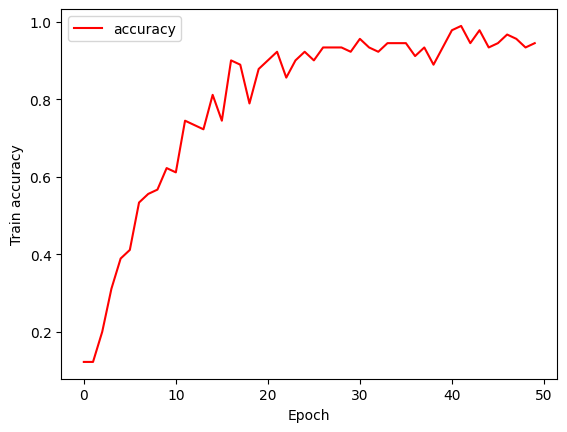

In [24]:
pd.DataFrame(history.history)[['accuracy']].plot(color='red')
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")

Text(0, 0.5, 'Validation accuracy')

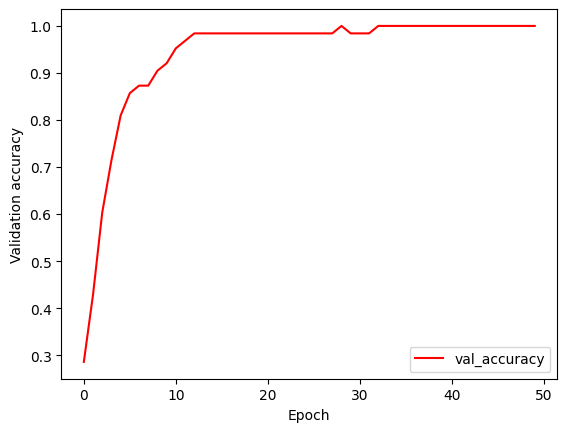

In [25]:
pd.DataFrame(history.history)[['val_accuracy']].plot(color='red')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")

Text(0, 0.5, 'Training loss')

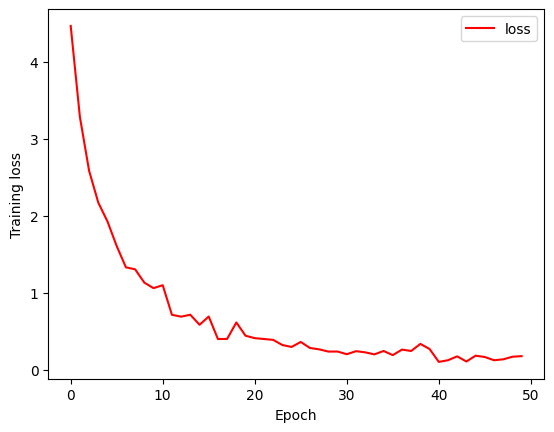

In [26]:
pd.DataFrame(history.history)[['loss']].plot(color='blue')
plt.xlabel("Epoch")
plt.ylabel("Training loss")

Text(0, 0.5, 'Validation loss')

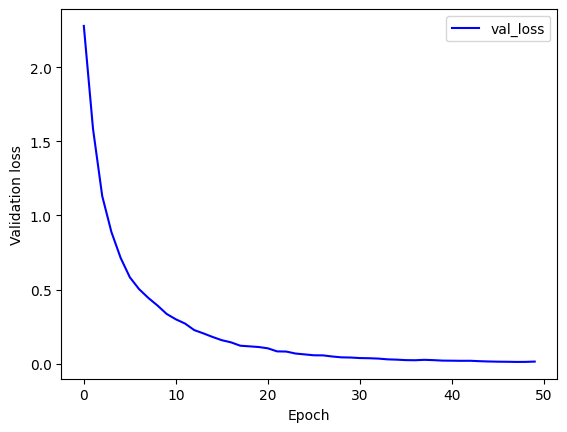

In [28]:
pd.DataFrame(history.history)[['val_loss']].plot(color='blue')
plt.xlabel("Epoch")
plt.ylabel("Validation loss")

In [29]:
true_labels = []
for _, (x, y) in enumerate(test_ds):
    true_labels.append(y)
    
true_labels = tf.cast(tf.concat(true_labels, axis=0), tf.int32)
pred_labels = tf.cast(tf.argmax(model.predict(test_ds), axis=-1), tf.int32)

11/11 [==============================] - 19s 1s/step


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [31]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



Axes(0.125,0.11;0.62x0.77)


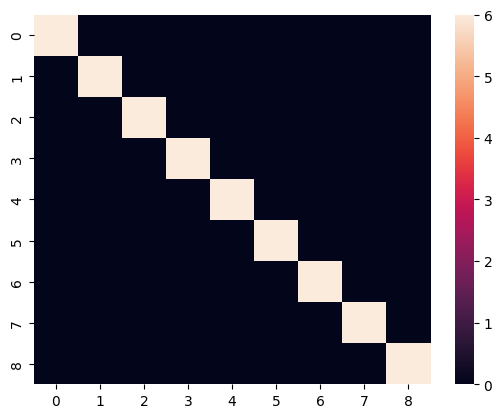

In [32]:
print(sns.heatmap(confusion_matrix(true_labels, pred_labels)))

True Label : Normal
Pred Label : Normal


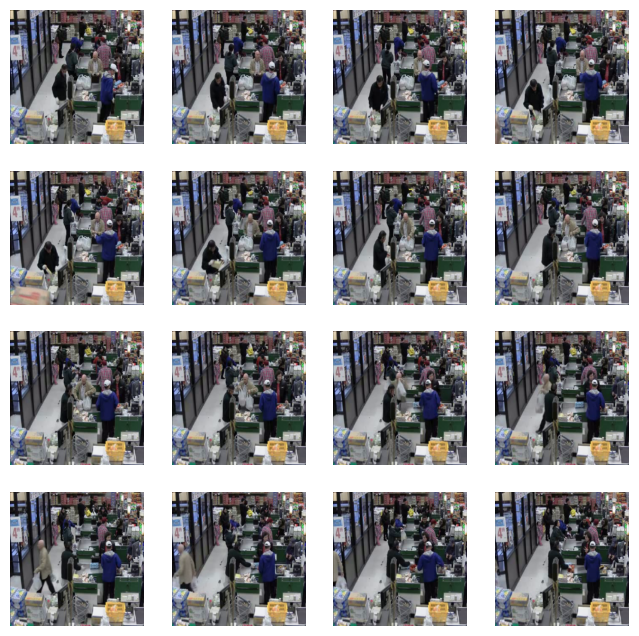

In [74]:
ind = 35
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Shoplifting
Pred Label : Shoplifting


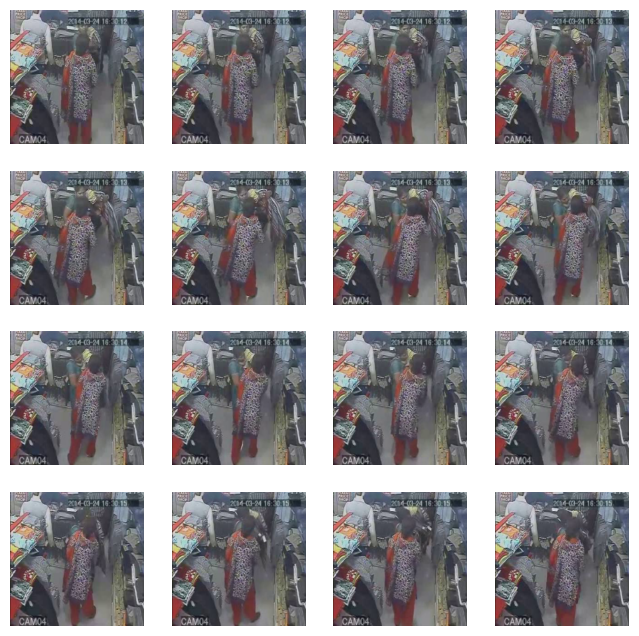

In [75]:
ind = 45
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Assault
Pred Label : Arson


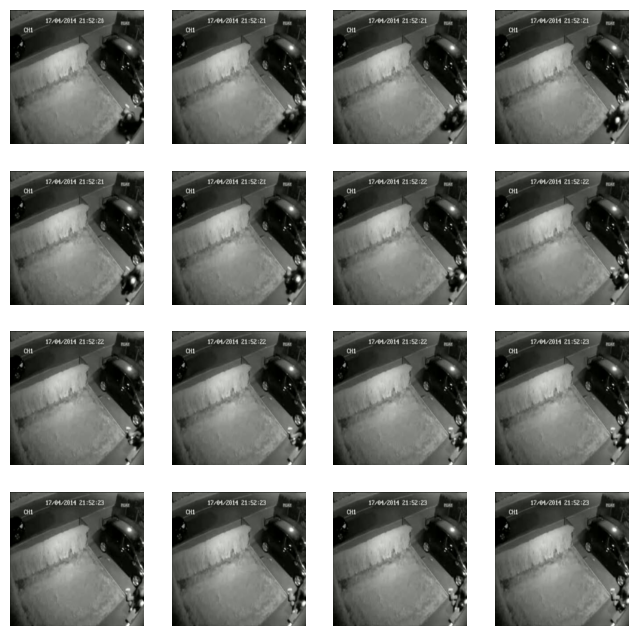

In [76]:
ind = 12
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Assault
Pred Label : Assault


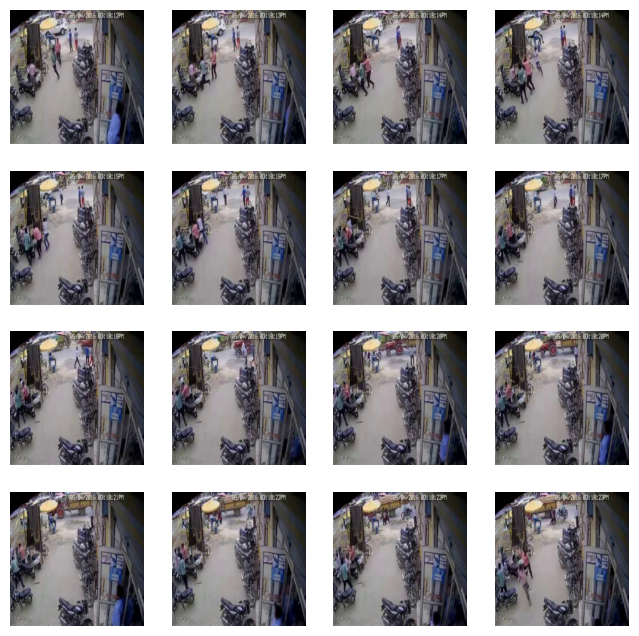

In [77]:
ind = 13
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Vandalism
Pred Label : Vandalism


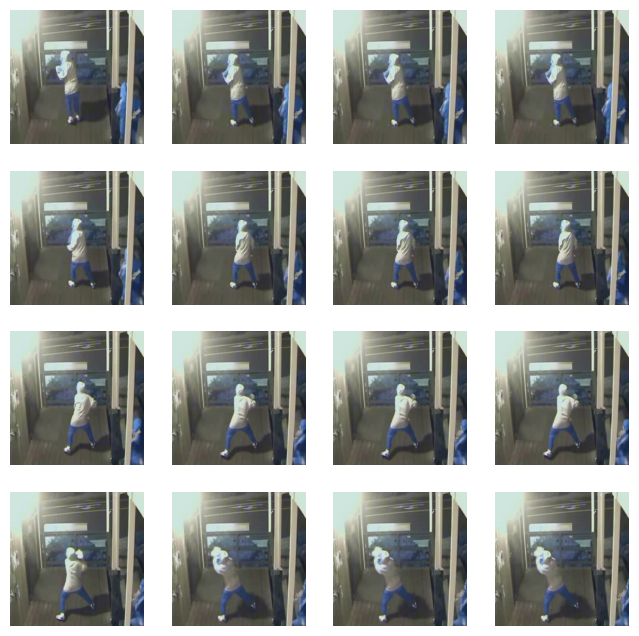

In [79]:
ind = -1
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Vandalism
Pred Label : Vandalism


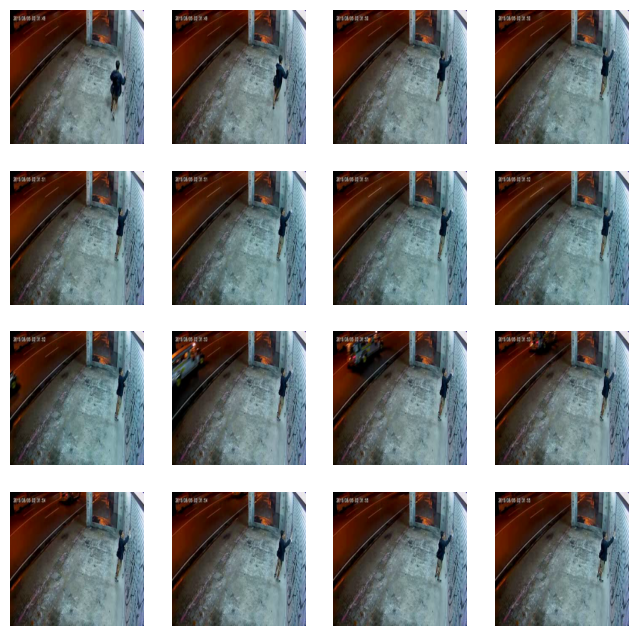

In [80]:
ind = -2
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Fighting
Pred Label : Fighting


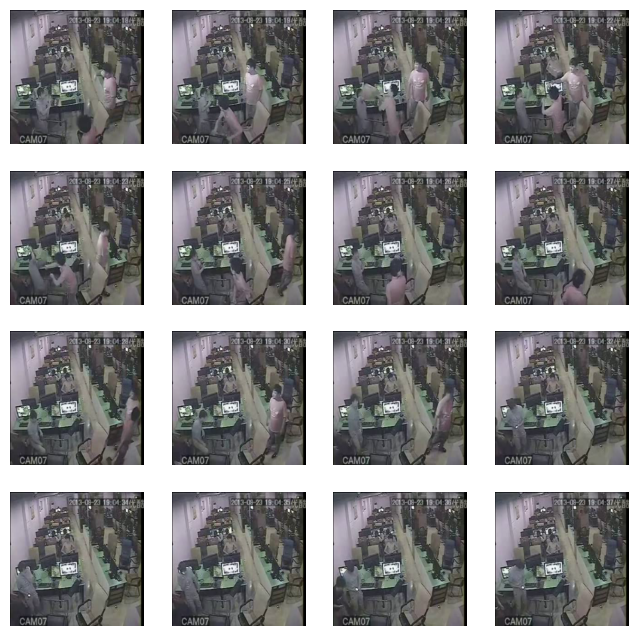

In [81]:
ind = 24
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Normal
Pred Label : Normal


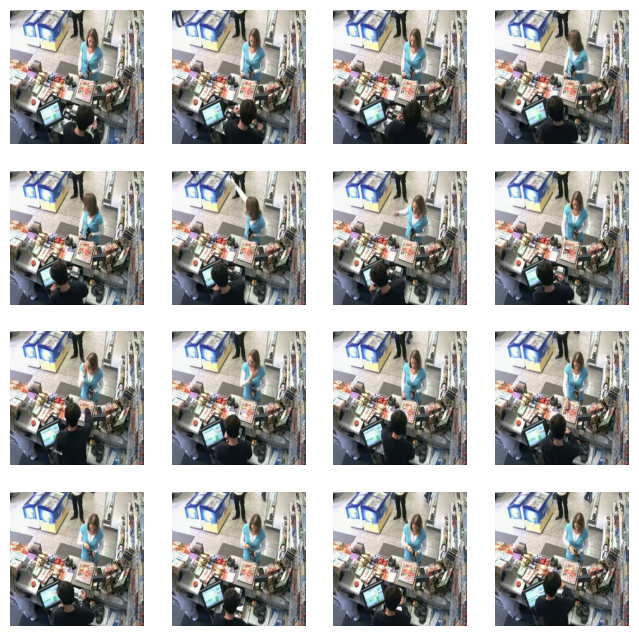

In [83]:
ind = 32
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Shooting
Pred Label : Shooting


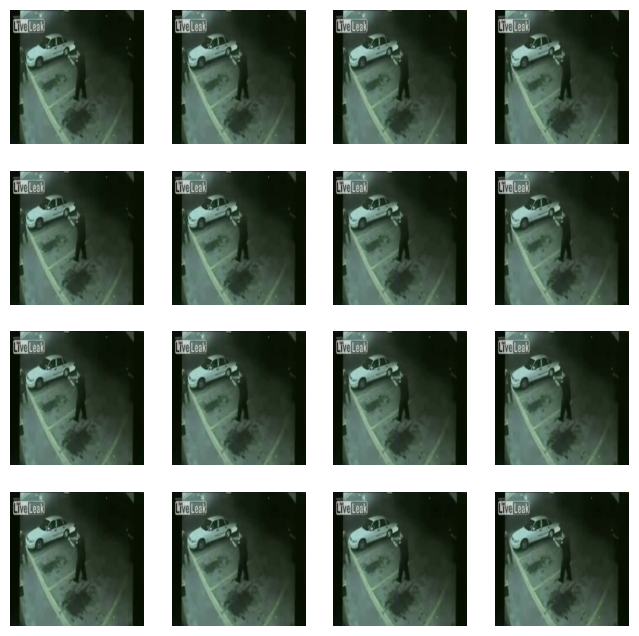

In [86]:
ind = 36
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Abuse
Pred Label : Abuse


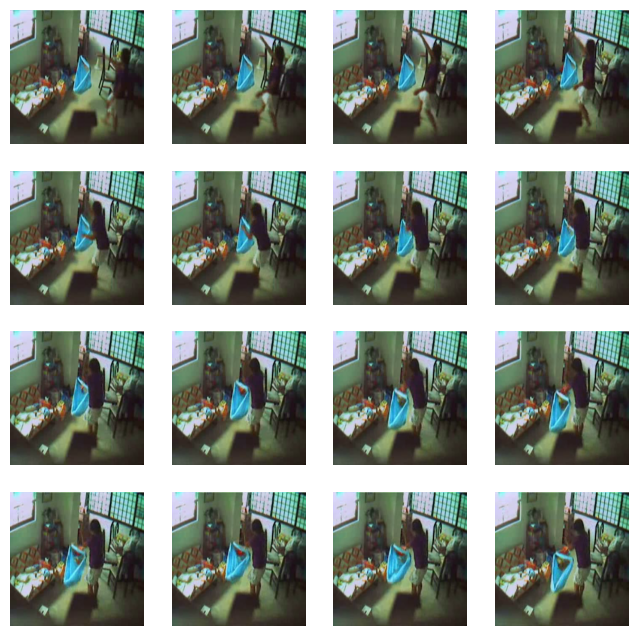

In [87]:
ind = 3
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Explosion
Pred Label : Explosion


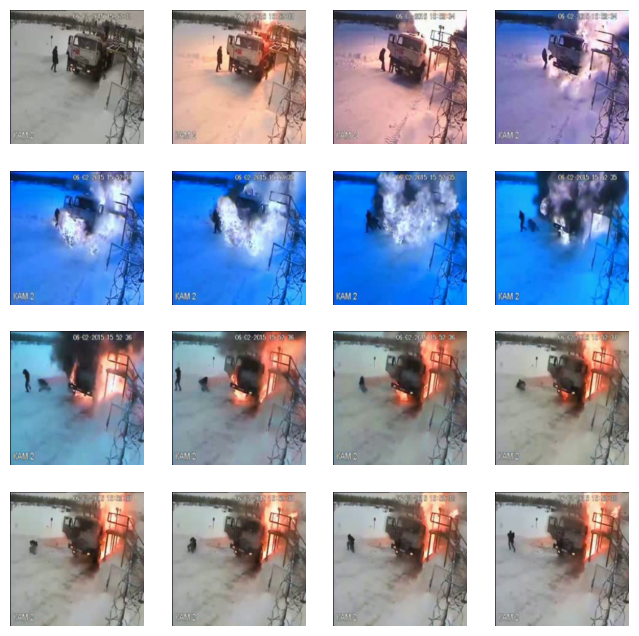

In [91]:
ind = 19
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

In [ ]:
ind = 27
fig, ax  = plt.subplots(4, 4, figsize=(8, 8))
video = true_video[ind]
video_frames = iter(video[0::2])

for i in range(4):
    for j in range(4):
        ax[i][j].axis('off')
        ax[i][j].imshow(next(video_frames))
        
print("True Label :", mappings_inv[true_labels.numpy().tolist()[ind]])
print("Pred Label :", mappings_inv[pred_labels.numpy().tolist()[ind]])

True Label : Fighting
Pred Label : Fighting
